In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
path = "D:\\Bootcamp\\MIMIC IV\\"
admissions = pd.read_csv(path + "core\\admissions.csv.gz", compression='gzip')
# patients = pd.read_csv(path + "core\\patients.csv.gz", compression='gzip')
# transfers = pd.read_csv(path + "core\\transfers.csv.gz", compression='gzip')

diagnoses = pd.read_csv(path + "hosp\\diagnoses_icd.csv.gz", compression='gzip')
d_diagnoses = pd.read_csv(path + "hosp\\d_icd_diagnoses.csv.gz", compression='gzip')
# drg_codes = pd.read_csv(path + "hosp\\drgcodes.csv.gz", compression='gzip')

d_lab_events = pd.read_csv(path + "hosp\\d_labitems.csv.gz", compression='gzip')

In [11]:
# d_lab_events = pd.read_csv(path + "hosp\\d_labitems.csv.gz", compression='gzip')

# Predict Future Diagnoses

Feasbility study to see if we can predict whether a patient will develop a disease (initially CHF) from their patient history leading up to (but not including) their first diagnosis. 

### Outline

1. Identify CHF patients
1. Look at patient histories
1. Look at co-morbidities
1. Identify first CHF diagnosis
1. Identify visit right before CHF diagnosis (< 1 mo)
1. Look for features to predict pre-CHF state (lab tests in history)

In [3]:
################################
pos_codes = d_diagnoses[(d_diagnoses['long_title'].str.lower().str.contains('congestive',)) & (d_diagnoses['long_title'].str.lower().str.contains('heart'))]
pos_codes

,icd_code,icd_version,long_title
4620,39891,9,Rheumatic heart failure (congestive)
4793,4280,9,"Congestive heart failure, unspecified"
22226,I5020,10,Unspecified systolic (congestive) heart failure
22227,I5021,10,Acute systolic (congestive) heart failure
22228,I5022,10,Chronic systolic (congestive) heart failure
22229,I5023,10,Acute on chronic systolic (congestive) heart f...
22230,I5030,10,Unspecified diastolic (congestive) heart failure
22231,I5031,10,Acute diastolic (congestive) heart failure
22232,I5032,10,Chronic diastolic (congestive) heart failure
22233,I5033,10,Acute on chronic diastolic (congestive) heart ...


In [4]:
###############################
pos_diagnoses = diagnoses[diagnoses['icd_code'].isin(pos_codes.icd_code)]
admissions['pos_subj'] = np.where(admissions.subject_id.isin(pos_diagnoses.subject_id), 1, 0)
admissions['pos_adm'] = np.where(admissions.hadm_id.isin(pos_diagnoses.hadm_id), 1, 0)

admissions['admittime'] = pd.to_datetime(admissions.admittime)
admissions = admissions.sort_values('admittime')
admissions['dischtime'] = pd.to_datetime(admissions.dischtime)
admissions['hadm_time'] = admissions.dischtime - admissions.admittime

admissions = admissions.rename(columns={'hospital_expire_flag':'expire_flag'})

In [6]:
primary_drg = drg_codes.drop('drg_code', axis=1).rename(columns={'description':'drg_code'})
primary_drg = primary_drg[['subject_id', 'hadm_id', 'drg_code']].drop_duplicates()
primary_drg = primary_drg.groupby('hadm_id').first().reset_index()
primary_drg.head()

,hadm_id,subject_id,drg_code
0,20000019,10467237,SEPTICEMIA OR SEVERE SEPSIS W/O MV 96+ HOURS W...
1,20000024,16925328,RED BLOOD CELL DISORDERS W/O MCC
2,20000041,18910522,Knee Joint Replacement
3,20000055,11868001,"Neonate, Bwt > 2499g, Normal Newborn Or Neonat..."
4,20000069,14546051,Vaginal Delivery


In [7]:
primary_icd = diagnoses[diagnoses['seq_num']==1].merge(d_diagnoses, how='left', on=['icd_version', 'icd_code'])
primary_icd = primary_icd.drop('icd_code', axis=1).rename(columns={'long_title':'icd_code'})
primary_icd = primary_icd[['subject_id', 'hadm_id', 'icd_code']].drop_duplicates()
primary_icd = primary_icd.groupby('hadm_id').first().reset_index()
primary_icd.head()

,hadm_id,subject_id,icd_code
0,20000019,10467237,Unspecified septicemia
1,20000024,16925328,Iron deficiency anemia secondary to blood loss...
2,20000034,19430048,Obstruction of bile duct
3,20000041,18910522,"Osteoarthrosis, localized, not specified wheth..."
4,20000055,11868001,"Single liveborn, born in hospital, delivered b..."


In [8]:
admissions = admissions.merge(primary_drg, how='left').merge(primary_icd, how='left')
admissions.head()

,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admission_location,discharge_location,insurance,language,marital_status,ethnicity,edregtime,edouttime,expire_flag,pos_subj,pos_adm,hadm_time,drg_code,icd_code
0,16904137,21081215,2105-10-04 17:26:00,2105-10-12 11:11:00,NaN,URGENT,TRANSFER FROM HOSPITAL,HOME,Other,ENGLISH,MARRIED,OTHER,NaN,NaN,0,0,0,7 days 17:45:00,NaN,NaN
1,12024697,20302177,2109-12-14 22:50:00,2110-01-15 14:53:00,NaN,EW EMER.,EMERGENCY ROOM,REHAB,Other,ENGLISH,MARRIED,WHITE,2109-12-14 19:31:00,2109-12-15 01:56:00,0,0,0,31 days 16:03:00,NaN,NaN
2,13308789,22079847,2110-01-11 00:57:00,2110-01-13 12:45:00,NaN,ELECTIVE,NaN,HOME,Other,ENGLISH,NaN,BLACK/AFRICAN AMERICAN,NaN,NaN,0,0,0,2 days 11:48:00,"Neonate, Bwt > 2499g, Normal Newborn Or Neonat...","Single liveborn, born in hospital, delivered w..."
3,15350437,20383396,2110-01-11 08:02:00,2110-01-12 18:45:00,NaN,EU OBSERVATION,TRANSFER FROM HOSPITAL,NaN,Other,ENGLISH,SINGLE,WHITE,2110-01-11 03:43:00,2110-01-11 08:41:00,0,0,0,1 days 10:43:00,NaN,"Sixth [abducent] nerve palsy, bilateral"
4,14742657,29081685,2110-01-11 09:53:00,2110-01-13 13:00:00,NaN,ELECTIVE,NaN,HOME,Other,ENGLISH,NaN,UNABLE TO OBTAIN,NaN,NaN,0,0,0,2 days 03:07:00,NaN,NaN


In [9]:
admissions.shape

(524520, 20)

# Move to EDA Notebook >>>>>>>>>>>>>>

In [17]:
# General trends in CHF population

In [10]:
admissions.groupby('ethnicity').agg({'pos_subj':['count', 'mean']})

pos_subj          
                                 count      mean
ethnicity                                       
AMERICAN INDIAN/ALASKA NATIVE     1536  0.152995
ASIAN                            24522  0.084210
BLACK/AFRICAN AMERICAN           80526  0.220997
HISPANIC/LATINO                  29887  0.164520
OTHER                            26844  0.122634
UNABLE TO OBTAIN                  3742  0.068145
UNKNOWN                          19419  0.099078
WHITE                           338044  0.196679

In [11]:
pos_index = admissions.groupby('subject_id').agg(pos_subj=('pos_subj', 'max'))
print(np.sum(pos_index))
print(np.mean(pos_index))

pos_subj    21137
dtype: int64
pos_subj    0.082128
dtype: float64


In [12]:
result = admissions.groupby('pos_subj').agg(total_adm=('hadm_id','count'),
                                             adm_fraction=('hadm_id', lambda x: len(x)/524520),
                                             death_count=('expire_flag', 'sum'),
                                             death_fraction=('expire_flag', 'mean'))
result['chance_of_death'] = result.death_fraction/result.adm_fraction
# ^^^ DOUBLE CHECK THIS LINE FOR BAYSIAN PROBABILITY ^^^
result

,total_adm,adm_fraction,death_count,death_fraction,chance_of_death
pos_subj,,,,,
0,427550,0.815126,6592,0.015418,0.018915
1,96970,0.184874,2777,0.028638,0.154904


In [13]:
admissions.expire_flag.sum()/admissions.subject_id.nunique()

0.03640340992982756

In [14]:
admissions[admissions.pos_subj == 1].expire_flag.sum()/admissions[admissions.pos_subj == 1].subject_id.nunique()

0.1313809906798505

In [15]:
# how long on avg does it take for someone to die with CHF

# <<<<<<<<<<<<<<<<<

In [16]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [17]:
pd.set_option('display.width', 1000)

In [18]:
rows = ['subject_id', 'admittime', 'pos_adm', 'expire_flag', 'drg_code', 'icd_code']
sample_adm = admissions[admissions.pos_subj==1][rows]
sample_adm['admittime'] = sample_adm.admittime.dt.date
for subj in sample_adm.sample(100).subject_id.unique():
    print('Subject: ', subj)
    print('-'*80)
    print(sample_adm[sample_adm.subject_id==subj][rows], '\n')

Subject:  13931815
--------------------------------------------------------------------------------
        subject_id   admittime  pos_adm  expire_flag                                           drg_code                                           icd_code
478805    13931815  2187-07-28        0            0                                                NaN                                                NaN
478909    13931815  2187-08-02        0            0                                                NaN                                                NaN
481240    13931815  2187-12-10        0            0                MAJOR CARDIOVASC PROCEDURES W/O MCC      Abdominal aneurysm without mention of rupture
481415    13931815  2187-12-19        0            0  MISC DISORDERS OF NUTRITION,METABOLISM,FLUIDS/...                                        Dehydration
482844    13931815  2188-03-05        0            0           Major Pancreas, Liver & Shunt Procedures                      

165323    19815670  2139-09-25        1            0  Percutaneous Cardiovascular Procedures w/o AMI  Other complications due to heart valve prosthesis 

Subject:  17132849
--------------------------------------------------------------------------------
        subject_id   admittime  pos_adm  expire_flag                                           drg_code                                           icd_code
254058    17132849  2153-02-20        0            0                                                NaN                                                NaN
255397    17132849  2153-05-09        0            0                                                NaN                                                NaN
259126    17132849  2153-12-11        1            0                                      Heart Failure                      Acute diastolic heart failure
275740    17132849  2156-07-14        1            0                               FOOT PROCEDURES W CC              Chronic o

        subject_id   admittime  pos_adm  expire_flag                                        drg_code                                           icd_code
463940    10719670  2185-04-30        0            0                                             NaN                                                NaN
465103    10719670  2185-07-01        0            0                                             NaN                                                NaN
465236    10719670  2185-07-08        0            0                                             NaN                                                NaN
505596    10719670  2193-10-04        0            0                          Knee Joint Replacement       Unilateral primary osteoarthritis, left knee
508014    10719670  2194-10-24        1            0                                             NaN  Hypertensive heart and chronic kidney disease ...
509286    10719670  2195-06-05        1            0  Percutaneous Cardiovascular Proced

438687    15455517  2181-05-26        0            0  TRACH W MV 96+ HRS OR PDX EXC FACE, MOUTH & NE...                          Acute respiratory failure 

Subject:  18747087
--------------------------------------------------------------------------------
        subject_id   admittime  pos_adm  expire_flag                                           drg_code                                           icd_code
312917    18747087  2162-03-19        0            0    Major Stomach, Esophageal & Duodenal Procedures                      Malignant neoplasm of pylorus
324426    18747087  2163-12-13        0            0  CARDIAC ARRHYTHMIA & CONDUCTION DISORDERS W/O ...                                Atrial fibrillation
324497    18747087  2163-12-18        0            0              Pulmonary Edema & Respiratory Failure                   Acute edema of lung, unspecified
328655    18747087  2164-08-06        0            0                                      Heart Failure                    

In [5]:
#################################
# find patients who have a negative visit right before a positive visit

first_admissions = admissions.iloc[admissions[admissions.pos_subj==1].groupby('subject_id').admittime.idxmin()]
subj_list = first_admissions[first_admissions.pos_adm==0].subject_id.unique()

print('There are', admissions[admissions.pos_subj==1].subject_id.nunique(), 'subjects with CHF, and',
      len(subj_list), 'subjects with CHF that had at a negative visit before CHF diagnosis.')

There are 21137 subjects with CHF, and 17406 subjects with CHF that had at a negative visit before CHF diagnosis.


In [20]:
# create dataframes for first positive visits and most recent previous visits

# create refernce dataframe
subj_admissions = admissions[admissions.subject_id.isin(subj_list)]
subj_admissions = subj_admissions.sort_values(['subject_id', 'admittime']).reset_index(drop=True)
pos_adm = subj_admissions[['subject_id', 'hadm_id', 'admittime', 'pos_adm']]
pos_adm = pos_adm.loc[pos_adm[pos_adm.pos_adm==1].groupby('subject_id').admittime.idxmin()]
pos_adm = pos_adm.rename(columns={'pos_adm':'first_pos'}).drop('admittime', axis=1)
subj_admissions = subj_admissions.merge(pos_adm, how='left')

# slice based on first visit/prior visit
first_idx = subj_admissions[subj_admissions.first_pos==1].index
pos_adm = subj_admissions.iloc[first_idx].reset_index(drop=True)
pre_adm = subj_admissions.iloc[first_idx-1].reset_index(drop=True)

#sanity checks
print('Positive cases in previous visit: ', pre_adm.pos_adm.sum())
print('Mismatched patient count: ', np.sum(pos_adm['subject_id'] - pre_adm['subject_id']))

Positive cases in previous visit:  0
Mismatched patient count:  0


In [21]:
pre_adm['time_delta'] = pos_adm.admittime - pre_adm.dischtime
pre_adm.time_delta.describe()

count                        9506
mean     591 days 11:42:02.682516
std      755 days 10:33:05.949361
min               0 days 00:00:00
25%              54 days 03:16:00
50%             286 days 21:10:30
75%             825 days 22:23:15
max            4329 days 05:22:00
Name: time_delta, dtype: object

Text(0, 0.5, 'Number of Patients')

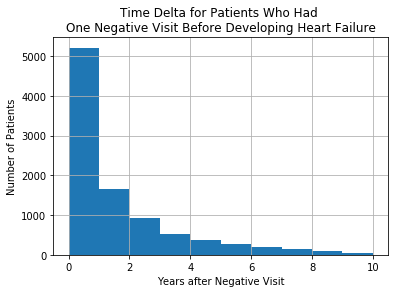

In [23]:
pre_adm['time_delta'].apply(lambda x: x.days/365).hist(bins=10, range=(0,10))
plt.title('Time Delta for Patients Who Had \nOne Negative Visit Before Developing Heart Failure')
plt.xlabel('Years after Negative Visit')
plt.ylabel('Number of Patients')

Text(0, 0.5, 'Number of Patients')

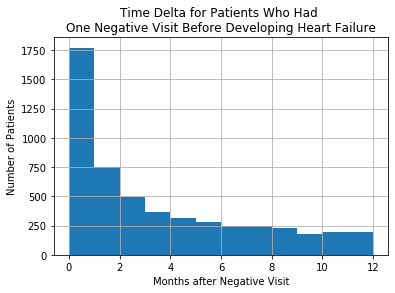

In [24]:
pre_adm['time_delta'].apply(lambda x: x.days/31).hist(bins=12, range=(0,12))
plt.title('Time Delta for Patients Who Had \nOne Negative Visit Before Developing Heart Failure')
plt.xlabel('Months after Negative Visit')
plt.ylabel('Number of Patients')

In [25]:
# select group of interest (< 1 year before diagnosis)

pre_adm1 = pre_adm[pre_adm.time_delta < pd.to_timedelta('365 days')]
pre_adm1.head()

,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admission_location,discharge_location,insurance,language,...,edregtime,edouttime,expire_flag,pos_subj,pos_adm,hadm_time,drg_code,icd_code,first_pos,time_delta
4,10002428,20321825,2156-04-30 20:35:00,2156-05-03 16:36:00,NaN,EW EMER.,EMERGENCY ROOM,CHRONIC/LONG TERM ACUTE CARE,Medicare,ENGLISH,...,2156-04-30 18:30:00,2156-04-30 21:53:00,0,1,0,2 days 20:01:00,Pulmonary Edema & Respiratory Failure,Acute respiratory failure,NaN,7 days 22:13:00
5,10002430,27218502,2125-06-23 09:00:00,2125-06-25 11:42:00,NaN,URGENT,PHYSICIAN REFERRAL,HOME HEALTH CARE,Medicare,ENGLISH,...,NaN,NaN,0,1,0,2 days 02:42:00,"Inguinal, Femoral & Umbilical Hernia Procedures","Unilateral inguinal hernia, with obstruction, ...",NaN,95 days 06:05:00
7,10003400,29483621,2136-11-04 20:43:00,2136-11-12 17:40:00,NaN,EW EMER.,EMERGENCY ROOM,SKILLED NURSING FACILITY,Medicare,ENGLISH,...,2136-11-04 16:08:00,2136-11-04 22:12:00,0,1,0,7 days 20:57:00,Digestive Malignancy,"Malignant neoplasm of other sites of rectum, r...",NaN,26 days 21:04:00
8,10003502,29391916,2165-12-24 04:45:00,2165-12-26 14:15:00,NaN,EU OBSERVATION,EMERGENCY ROOM,NaN,Medicare,?,...,2165-12-24 00:42:00,2165-12-24 06:41:00,0,1,0,2 days 09:30:00,NaN,Atrial flutter,NaN,50 days 22:51:00
9,10003637,23487925,2146-01-22 23:08:00,2146-01-26 14:02:00,NaN,OBSERVATION ADMIT,EMERGENCY ROOM,HOME HEALTH CARE,Other,ENGLISH,...,2146-01-22 11:12:00,2146-01-23 00:33:00,0,1,0,3 days 14:54:00,Minor Small & Large Bowel Procedures,Rectal abscess,NaN,23 days 02:47:00


In [44]:
#### RESERVED FOR LAB TESTS

# look for labs from visit right before CHF

# load lab tests
lab_events = pd.read_pickle("lab_events_final.pkl")
labs_adm1 = lab_events[lab_events.subject_id.isin(pre_adm1.subject_id)]
labs_adm1 = labs_adm1.merge(d_lab_events, how='left', on='itemid')
labs_adm1.subject_id.nunique()

###

111

In [37]:
print('There are %i target patients who had one negative hospital visit within one year of heart failure.' % pre_adm1.shape[0])
print('On average, they had %i days before the diagnosis of heart failure.' % pre_adm1.time_delta.dt.days.mean())
print('For the lab tests, there are %i patients without any lab tests.' % (pre_adm1.shape[0] - labs_adm1.subject_id.nunique()))
print('For those with lab tests, there were %.1f tests run per patient.' % (labs_adm1.shape[0]/pre_adm1.shape[0]))

There are 5210 target patients who had one negative hospital visit within one year of heart failure.
On average, they had 106 days before the diagnosis of heart failure.
For the lab tests, there are 5099 patients without any lab tests.
For those with lab tests, there were 49.3 tests run per patient.


In [113]:
pd.set_option('max_rows', 100) 
pd.set_option('min_rows', 100)        # display at least 100 rows when max is exceeded

# ARCHIVE >>>>>>>>>>>>>>>>>>

# Emergency EDA on Lab Tests

Outline:
1. Understand overall lab tests
1. Load all tests for CHF patients (subj_list)
1. Analyze most common tests for CHF

In [2]:
# repeat setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

path = "D:\\Bootcamp\\MIMIC IV\\"
admissions = pd.read_csv(path + "core\\admissions.csv.gz", compression='gzip')
diagnoses = pd.read_csv(path + "hosp\\diagnoses_icd.csv.gz", compression='gzip')
d_diagnoses = pd.read_csv(path + "hosp\\d_icd_diagnoses.csv.gz", compression='gzip')
d_lab_events = pd.read_csv(path + "hosp\\d_labitems.csv.gz", compression='gzip')

###############################
pos_codes = d_diagnoses[(d_diagnoses['long_title'].str.lower().str.contains('congestive',)) & (d_diagnoses['long_title'].str.lower().str.contains('heart'))]
pos_diagnoses = diagnoses[diagnoses['icd_code'].isin(pos_codes.icd_code)]
admissions['pos_subj'] = np.where(admissions.subject_id.isin(pos_diagnoses.subject_id), 1, 0)
admissions['pos_adm'] = np.where(admissions.hadm_id.isin(pos_diagnoses.hadm_id), 1, 0)
admissions['admittime'] = pd.to_datetime(admissions.admittime)

###############################
first_hadm = admissions.iloc[admissions[admissions.pos_adm==1].groupby('subject_id').admittime.idxmin()]
hadm_list = first_hadm.hadm_id

In [117]:
# look at overall lab events
d_lab_events.groupby(['fluid', 'category']).agg(total_count=('itemid',lambda x: len(np.unique(x)))).sort_values(by='total_count', ascending=False)

total_count
fluid               category               
Blood               Chemistry           410
                    Hematology          342
Urine               Chemistry           111
Other Body Fluid    Chemistry            99
                    Hematology           93
Urine               Hematology           79
Cerebrospinal Fluid Hematology           69
Bone Marrow         Hematology           62
Blood               Blood Gas            49
Joint Fluid         Hematology           45
Ascites             Hematology           39
Pleural             Hematology           39
Stool               Chemistry            37
Cerebrospinal Fluid Chemistry            32
Pleural             Chemistry            30
Ascites             Chemistry            29
Joint Fluid         Chemistry            27
Q                   Hematology            9
Other Body Fluid    Blood Gas             7
Stool               Hematology            6
Fluid               Blood Gas             5
Urine               Blood Gas             4
I                   Hematology            1
Bone Marrow         Chemistry             1

In [4]:
%%time
# load *ALL* tests

chunksize = 3*(10 ** 6)
chunk = 1
cols_ = ['subject_id', 'hadm_id', 'specimen_id', 'itemid', 'value', 'valuenum', 'valueuom', \
         'ref_range_lower', 'ref_range_upper', 'priority', 'comments']
lab_events = []
for lab_chunk in pd.read_csv(path + "hosp\\labevents.csv.gz", compression='gzip', chunksize=chunksize):
    lab_chunk = lab_chunk[lab_chunk.hadm_id.isin(hadm_list)]
    lab_chunk = lab_chunk[cols_]
    lab_events.append(lab_chunk)
    print(f'Processed chunk: {chunk}')
    chunk += 1

# 5k patients
# 3min 52s

# 10k patients
# 4min 6s

# 15k patients
# 4min 27s


Processed chunk: 1
Processed chunk: 2
Processed chunk: 3


<string>:2: DtypeWarning: Columns (7,9,12) have mixed types.Specify dtype option on import or set low_memory=False.


Processed chunk: 4
Processed chunk: 5
Processed chunk: 6
Processed chunk: 7
Processed chunk: 8
Processed chunk: 9


<string>:2: DtypeWarning: Columns (9,12) have mixed types.Specify dtype option on import or set low_memory=False.


Processed chunk: 10


<string>:2: DtypeWarning: Columns (12) have mixed types.Specify dtype option on import or set low_memory=False.


Processed chunk: 11
Processed chunk: 12
Processed chunk: 13
Processed chunk: 14
Processed chunk: 15


<string>:2: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.


Processed chunk: 16
Processed chunk: 17
Processed chunk: 18
Processed chunk: 19
Processed chunk: 20
Processed chunk: 21
Processed chunk: 22
Processed chunk: 23


<string>:2: DtypeWarning: Columns (7,9) have mixed types.Specify dtype option on import or set low_memory=False.


Processed chunk: 24
Processed chunk: 25
Processed chunk: 26
Processed chunk: 27
Processed chunk: 28
Processed chunk: 29
Processed chunk: 30
Processed chunk: 31
Processed chunk: 32
Processed chunk: 33
Processed chunk: 34
Processed chunk: 35
Processed chunk: 36
Processed chunk: 37
Processed chunk: 38
Processed chunk: 39
Processed chunk: 40
Processed chunk: 41
Wall time: 5min 53s


In [5]:
lab_events = pd.concat(lab_events)

In [6]:
lab_events.to_pickle("./lab_events.pkl")

In [15]:
chf_labs = lab_events.merge(d_lab_events, how='left', on='itemid')
chf_labs = chf_labs.groupby(['itemid', 'label', 'fluid', 'category']).agg(freq=('subject_id', lambda x: len(np.unique(x))/chf_labs.subject_id.nunique()))\
.reset_index().sort_values('freq', ascending=False).head(40)

Text(0.5, 1.0, 'Percent of Heart Failure Patients Who\n Had The Top N Tests')

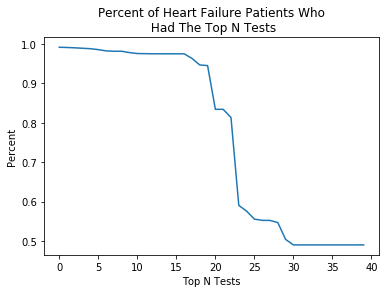

In [13]:
chf_labs['freq'].reset_index(drop=True).plot(kind='line')
plt.xlabel('Top N Tests')
plt.ylabel('Percent')
plt.title('Percent of Heart Failure Patients Who\n Had The Top N Tests')

In [16]:
print(chf_labs.reset_index(drop=True))

    itemid                            label  fluid    category      freq
0    50971                        Potassium  Blood   Chemistry  0.991724
1    50912                       Creatinine  Blood   Chemistry  0.991095
2    51006                    Urea Nitrogen  Blood   Chemistry  0.990272
3    50983                           Sodium  Blood   Chemistry  0.989111
4    50902                         Chloride  Blood   Chemistry  0.987998
5    51221                       Hematocrit  Blood  Hematology  0.985675
6    51265                   Platelet Count  Blood  Hematology  0.982481
7    50868                        Anion Gap  Blood   Chemistry  0.981513
8    50882                      Bicarbonate  Blood   Chemistry  0.981513
9    50931                          Glucose  Blood   Chemistry  0.978174
10   51301                White Blood Cells  Blood  Hematology  0.975754
11   51222                       Hemoglobin  Blood  Hematology  0.975415
12   51249                             MCHC  Blood 

# <<<<<<<<<<<< ARCHIVE